# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

In [3]:
sys.executable

'/home/akarshkumar0101/miniconda3/bin/python'

In [4]:
import torch
import clip
from PIL import Image

model, preprocess = clip.load("ViT-B/32", device=device)


In [5]:
image = preprocess(Image.open("imgs/dog.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[9.193e-04 9.927e-01 6.283e-03]]


/home/akarshkumar0101/miniconda3/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
import optimization

  0%|                                                                                                                                                                                                                | 0/2000 [00:00<?, ?it/s]

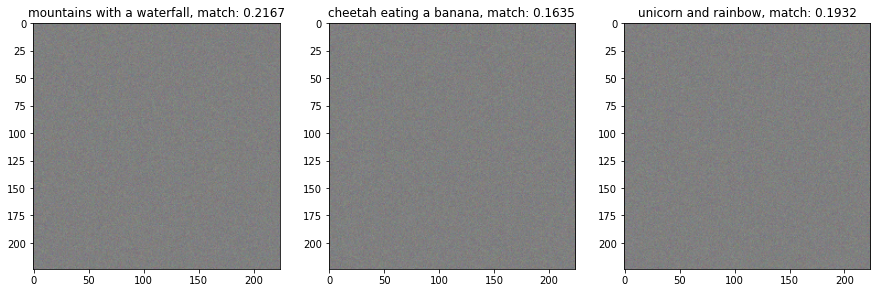

 10%|███████████████████▋                                                                                                                                                                                  | 199/2000 [00:11<01:40, 17.84it/s]

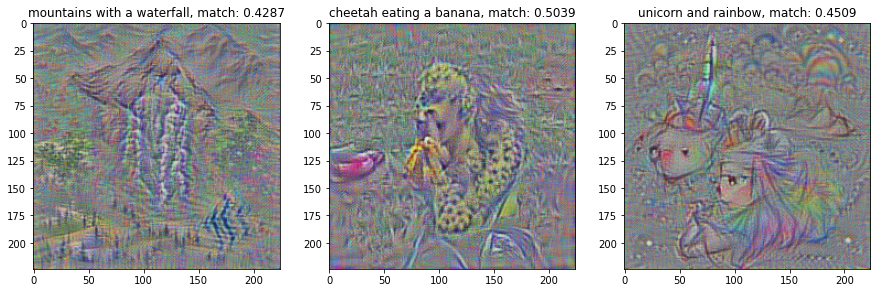

 20%|███████████████████████████████████████▌                                                                                                                                                              | 400/2000 [00:22<01:30, 17.77it/s]

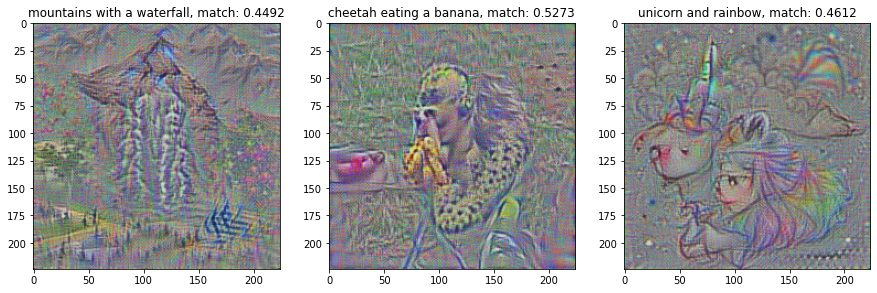

 24%|████████████████████████████████████████████████▏                                                                                                                                                     | 487/2000 [00:28<01:27, 17.33it/s]


RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [9]:
torch.manual_seed(1032)

texts = ["mountains with a waterfall", "cheetah eating a banana", "unicorn and rainbow"]

def callback(i_iteration, texts, imgs, imgs_augments, imgs_features, texts_features, dots, loss):
    if i_iteration%200==0:
        dots_img = dots.mean(dim=0).tolist()
        plt.figure(figsize=(5*len(imgs), 5))
        for i_img, img in enumerate(imgs):
            plt.subplot(1, len(imgs), i_img+1)
            plt.title(texts[i_img] + f', match: {dots_img[i_img]:.4f}')
            plt.imshow(to_np(img.permute(1, 2, 0)))
        plt.show()
        
    
    
optimization.optimize_imgs(model, texts, imgs='pixel', n_iterations=2000, lr=5e-2, device=device, callback=callback)

In [ ]:
def imshow(img, mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]):
    """
    img.shape should be (3, h, w) on any device, torch tensor
    """
    img = img.detach().cpu()
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    img = img.permute(1, 2, 0)
    img = img*std+mean
    img = img.clamp(0, 1).numpy()
    plt.imshow(img)
    
    

In [ ]:
from torchvision import transforms

augment_trans = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5, p=1, fill=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
])

def augment_img(img, n_augments, augment='noise'):
    imgs = [img]
    
    if augment=='noise':
        for i in range(n_augments):
            imgs.append(img+1e-2*torch.randn_like(img))
    if augment=='crops':
        for i in range(n_augments):
            imgs.append(augment_trans(img))
    
    return torch.cat(imgs, dim=0)

# Optimizing Pixels

In [ ]:

text = clip.tokenize(["mountains with a waterfall"]).to(device)
text_features = model.encode_text(text)
target = text_features[0].detach()

torch.manual_seed(5)

img = 1e-2*torch.randn(1, 3, 224, 224)
img = img.to(device)
# img = img.requires_grad_()
img.requires_grad = True

opt = torch.optim.Adam([img], lr=3e-2, weight_decay=1e-6)

for i in tqdm(range(10000)):
    img_augments = augment_img(img, 4, augment='crops')
    image_features = model.encode_image(img_augments)
    
    dots = torch.cosine_similarity(image_features, target)
    loss = -dots.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%200==0:
        print(loss.item())
        imshow(img[0])
        plt.show()



# CPPN Definition

In [ ]:
from torch import nn

# Optimizing CPPN for XOR

In [ ]:
cppn = ImageCPPN(n_channels=3)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-2)

for i in tqdm(range(100)):
    
    x = cppn.generate_image((100, 100))[0]
    
    # loss = x[0, [1, 2], 0, 0].mean().pow(2) + x[0, [0, 2], -1, -1].mean().pow(2)
    half = x.shape[-1]//2
    loss = (x[0,:half,:half]).pow(2).mean() + (x[[0,1],half:,half:]).pow(2).mean() + (1.-x[0,half:,:half]).pow(2).mean() + (1.-x[0,:half,half:]).pow(2).mean()
    # loss = (1.-x).pow(2).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%10==0:
        # plt.imshow(x[0].detach().cpu(), vmin=0, vmax=1)
        # plt.colorbar()
        imshow(x)
        plt.show()
    

In [ ]:
cppn = ImageCPPN(n_channels=3)
np.sum([p.numel() for p in cppn.parameters()])

# Optimizing CPPN to a CLIP Text

In [ ]:
from image_cppn import ImageCPPN

In [ ]:
print('starting')
text = clip.tokenize(["dog eating a banana"]).to(device)
text_features = model.encode_text(text)
target = text_features[0].detach()

torch.manual_seed(5)

cppn = ImageCPPN(n_hidden=20, n_layers=8, n_channels=3, activation=torch.relu, give_radius=True)
cppn = cppn.to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)#, weight_decay=1e-6)

for i in tqdm(range(10000)):
    img = cppn.generate_image((224, 224))
    img = img*2-1.
    img_augments = augment_img(img, 4, augment='crops')
    image_features = model.encode_image(img_augments)
    
    dots = torch.cosine_similarity(image_features, target)
    loss = -dots.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%200==0:
        print(loss.item())
        imshow(img[0])
        plt.show()



# Optimizing CPPN to a target image (does not work in the slightest)
I think this is expected though...
https://silky.github.io/cppn-playground/

In [ ]:
target = preprocess(Image.open("dog.png"))

In [ ]:
imshow(target)

In [ ]:
torch.manual_seed(5)

cppn = ImageCPPN()
cppn = cppn.to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)#, weight_decay=1e-6)

for i in tqdm(range(100)):
    img = cppn.generate_image((224, 224))
    loss = (img-target.to(img)).pow(2).mean()
    
    opt.zero_grad()
    loss.backward()
    a = torch.cat([p.grad.flatten() for p in cppn.parameters()]).detach()
    b = torch.cat([p.flatten() for p in cppn.parameters()]).detach()
    opt.step()
    print(a.abs().min().item(), a.abs().mean().item(), a.abs().max().item())
    print(b.abs().min().item(), b.abs().mean().item(), b.abs().max().item())
    print()

    if i%10==0:
        print("Loss: ", loss.item())
        imshow(img[0])
        plt.show()
